In [1]:
from __future__ import annotations

from pathlib import Path
import math
import sys
from typing import Dict, List, Sequence, Optional

import numpy as np
import numpy.linalg as npla
import pandas as pd

# Keep tables readable in notebook output.
pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 30)

import matplotlib.pyplot as plt

# Resolve the project root by walking upward until a "data/" directory is found.
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").is_dir():
    for parent in PROJECT_ROOT.parents:
        if (parent / "data").is_dir():
            PROJECT_ROOT = parent
            break

DATA      = PROJECT_ROOT / "data"
PROCESSED = DATA / "processed"
ANALYSIS  = DATA / "analysis"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA       :", DATA)
print("ANALYSIS   :", ANALYSIS)

# Weekly core + universe files (same naming as weekly_processing / Experiment 3).
CORE_FULL_FILE  = PROCESSED / "crsp_weekly_core.parquet"
CORE_TRAIN_FILE = PROCESSED / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"
CORE_VAL_FILE   = PROCESSED / "crsp_weekly_core_2018-06-30_to_2024-12-30.parquet"

UNIV_TRAIN_FILE = PROCESSED / (
    "crsp_weekly_universe_1997-01-01_to_2018-06-29_top1000_"
    "liq20p_rebalance-monthly_W-FRI.parquet"
)
UNIV_VAL_FILE = PROCESSED / (
    "crsp_weekly_universe_2018-06-30_to_2024-12-30_top1000_"
    "liq20p_rebalance-monthly_W-FRI.parquet"
)
UNIV_FULL_FILE = PROCESSED / "crsp_weekly_universe_top1000.parquet"

# Monthly files (only needed if you later add monthly EW/CapW benchmarks).
MONTHLY_CORE_FILE    = PROCESSED / "crsp_monthly_core.parquet"
MONTHLY_UNIV_TOP1000 = PROCESSED / "crsp_monthly_universe_top1000.parquet"

# MI kernel artifacts (bits). Prefer the sqrt-tagged file, but keep a fallback.
MI_DEFAULT  = ANALYSIS / "mi_bits_tier1_asof20180629_k6_min156_sqrt.parquet"
MI_FALLBACK = ANALYSIS / "mi_bits_tier1_asof20180629_k6_min156.parquet"

# Add src/ and the notebook-local ksg_tools.py location to sys.path so imports work in-place.
SRC            = PROJECT_ROOT / "src"
KSG_TOOLS_PATH = PROJECT_ROOT / "notebooks" / "weekly" / "ksg_tools.py"
if SRC.exists() and str(SRC) not in sys.path:
    sys.path.append(str(SRC))
if KSG_TOOLS_PATH.exists() and str(KSG_TOOLS_PATH.parent) not in sys.path:
    sys.path.append(str(KSG_TOOLS_PATH.parent))

print("MI_DEFAULT exists? ", MI_DEFAULT.exists())
print("MI_FALLBACK exists?", MI_FALLBACK.exists())
print("KSG tools exists?  ", KSG_TOOLS_PATH.exists())

# Experiment-wide dates and knobs.
import pandas as _pd

TRAIN_START = _pd.Timestamp("1997-01-01")
ASOF_TRAIN  = _pd.Timestamp("2018-06-29")
TRAIN_END   = ASOF_TRAIN

VAL_START   = _pd.Timestamp("2018-06-30")
VAL_END     = _pd.Timestamp("2024-12-30")

WEEKS_PER_YEAR = 52

# GMV training settings (to match the Experiment 3 spec).
GMV_COVERAGE_FLOOR = 52
SHRINK_ALPHA       = 0.10
SIGMA_RIDGE        = 1e-6

# Kernel stabilization settings (same as the main Q build).
Q_RIDGE_MIN_EIG = 1e-6
Q_KAPPA_MAX     = 1e8

# KSG/MI settings used in later levers.
MI_MIN_OBS       = 156
KSG_K_BASE       = 6
KSG_N_SHUFFLES   = 20
KSG_SHUFFLE_SEED = 1235

PROJECT_ROOT: C:\Users\bseis\ABthesis
DATA       : C:\Users\bseis\ABthesis\data
ANALYSIS   : C:\Users\bseis\ABthesis\data\analysis
MI_DEFAULT exists?  True
MI_FALLBACK exists? True
KSG tools exists?   True


In [2]:
# Utility helpers: PSD projection, ridge choice, performance metrics

from typing import Tuple

def nearest_psd(A: np.ndarray, eps_eig: float = 0.0) -> np.ndarray:
    """
    PSD projection via eigenvalue clipping (symmetric Frobenius-nearest style).
    """
    A = np.asarray(A, dtype="float64")
    A = 0.5 * (A + A.T)
    evals, evecs = npla.eigh(A)
    evals_clipped = np.maximum(evals, eps_eig)
    return (evecs * evals_clipped) @ evecs.T

def choose_ridge(Q: np.ndarray, max_cond: float = 1e7, min_eig: float = 1e-5) -> float:
    """
    Pick a diagonal ridge λ for numerical stability.

    Goal:
      - push the minimum eigenvalue above min_eig
      - keep the condition number under max_cond when possible
    """
    Q = np.asarray(Q, dtype="float64")
    Q = 0.5 * (Q + Q.T)
    evals = npla.eigvalsh(Q)
    lam_min = float(evals.min())
    base = max(0.0, min_eig - lam_min)

    # If the minimum-eigenvalue fix already yields acceptable conditioning, stop.
    Q_reg = Q + base * np.eye(Q.shape[0])
    evals_reg = npla.eigvalsh(Q_reg)
    cond = float(evals_reg.max() / max(evals_reg.min(), 1e-12))
    if cond <= max_cond:
        return base

    # Otherwise walk λ up by decades until conditioning is reasonable (or we give up).
    lam = base if base > 0 else min_eig
    for _ in range(20):
        lam *= 10.0
        Q_reg = Q + lam * np.eye(Q.shape[0])
        evals_reg = npla.eigvalsh(Q_reg)
        cond = float(evals_reg.max() / max(evals_reg.min(), 1e-12))
        if cond <= max_cond:
            return lam
    return lam

def weighted_returns(R: pd.DataFrame, w: np.ndarray) -> pd.Series:
    """
    Portfolio returns from a wide return panel.

    Missing data is handled by renormalizing weights over the names that have a return
    on that date (same convention as Experiment 3).
    """
    R_vals = np.asarray(R.values, dtype="float64")
    mask = np.isfinite(R_vals)
    w_row = np.broadcast_to(w, R_vals.shape)
    w_masked = np.where(mask, w_row, 0.0)
    row_sums = w_masked.sum(axis=1)
    row_sums[row_sums == 0.0] = np.nan
    w_norm = w_masked / row_sums[:, None]
    R_filled = np.where(mask, R_vals, 0.0)
    port_ret = np.einsum("ij,ij->i", w_norm, R_filled)
    return pd.Series(port_ret, index=R.index, name="ret")

def to_cum_simple(ret: pd.Series) -> pd.Series:
    # Multiplicative wealth curve from simple returns.
    return (1.0 + ret.fillna(0.0)).cumprod()

def ann_sharpe(ret: pd.Series, rf_weekly: float = 0.0) -> float:
    # Annualized Sharpe ratio from weekly returns.
    ex = ret.dropna() - rf_weekly
    if ex.empty:
        return float("nan")
    mu, sd = ex.mean(), ex.std(ddof=1)
    if sd <= 0 or not np.isfinite(sd):
        return float("nan")
    return float((mu / sd) * math.sqrt(WEEKS_PER_YEAR))

def max_drawdown(ret: pd.Series) -> float:
    # Max drawdown on the cumulative wealth curve.
    r = ret.fillna(0.0)
    wealth = to_cum_simple(r)
    peak = wealth.cummax()
    dd = (wealth - peak) / peak
    return float(dd.min())

def downside_deviation(ret: pd.Series, mar: float = 0.0) -> float:
    # Annualized downside deviation relative to a weekly MAR.
    ex = ret.dropna() - mar
    if ex.empty:
        return float("nan")
    downside = np.minimum(0.0, ex.to_numpy(dtype="float64"))
    var = np.mean(downside**2)
    return float(math.sqrt(var) * math.sqrt(WEEKS_PER_YEAR))

def sortino(ret: pd.Series, mar: float = 0.0) -> float:
    # Sortino ratio using downside deviation as the denominator.
    ex = ret.dropna() - mar
    if ex.empty:
        return float("nan")
    dd_week = downside_deviation(ret, mar=mar) / math.sqrt(WEEKS_PER_YEAR)
    if dd_week <= 0 or not np.isfinite(dd_week):
        return float("nan")
    mu = ex.mean()
    return float(mu / dd_week)

def calmar(ret: pd.Series) -> float:
    # Calmar ratio: CAGR divided by |max drawdown|.
    r = ret.dropna()
    if r.empty:
        return float("nan")
    ann_ret = float((1.0 + r).prod() ** (WEEKS_PER_YEAR / len(r)) - 1.0)
    mdd = abs(max_drawdown(r))
    if mdd <= 0 or not np.isfinite(mdd):
        return float("nan")
    return float(ann_ret / mdd)

def info_ratio(ret: pd.Series, bench: pd.Series) -> float:
    # Annualized information ratio vs benchmark.
    a, b = ret.align(bench, join="inner")
    diff = (a - b).dropna()
    if diff.empty:
        return float("nan")
    mu, sd = diff.mean(), diff.std(ddof=1)
    if sd <= 0 or not np.isfinite(sd):
        return float("nan")
    return float((mu / sd) * math.sqrt(WEEKS_PER_YEAR))

def perf_summary(
    rets: pd.Series,
    bench: Optional[pd.Series] = None,
    name: str = "",
) -> Dict[str, float]:
    # Bundle the standard Experiment-3 metrics into a single row.
    r = rets.dropna()
    if r.empty:
        return dict(
            strategy=name,
            N=0,
            ann_ret=np.nan,
            ann_vol=np.nan,
            sharpe=np.nan,
            info_ratio=np.nan,
            mdd=np.nan,
            sortino=np.nan,
            calmar=np.nan,
            dd_dev=np.nan,
        )
    ann_ret = float((1.0 + r).prod() ** (WEEKS_PER_YEAR / len(r)) - 1.0)
    ann_vol = float(r.std(ddof=1) * math.sqrt(WEEKS_PER_YEAR))
    sh = ann_sharpe(r)
    ir = float("nan") if bench is None else info_ratio(r, bench)
    mdd = max_drawdown(r)
    sor = sortino(r)
    cal = calmar(r)
    ddv = downside_deviation(r)
    return dict(
        strategy=name,
        N=len(r),
        ann_ret=ann_ret,
        ann_vol=ann_vol,
        sharpe=sh,
        info_ratio=ir,
        mdd=mdd,
        sortino=sor,
        calmar=cal,
        dd_dev=ddv,
    )

def gmv_weights(Sigma: np.ndarray) -> np.ndarray:
    # GMV weights in closed form (pseudo-inverse for robustness).
    inv = npla.pinv(Sigma)
    ones = np.ones(Sigma.shape[0])
    w = inv @ ones
    w /= ones @ w
    return np.asarray(w, dtype="float64")

def gmrp_weights(Q: np.ndarray) -> np.ndarray:
    # GMRP weights in closed form (pseudo-inverse for robustness).
    inv = npla.pinv(Q)
    ones = np.ones(Q.shape[0])
    w = inv @ ones
    w /= ones @ w
    return np.asarray(w, dtype="float64")

def redundancy_sigma_Q(Q: np.ndarray, w: np.ndarray) -> float:
    # sigma_Q on a fixed weight vector.
    return float(np.sqrt(np.maximum(0.0, w.T @ Q @ w)))

def map_weights_to_static_universe(
    w_train: np.ndarray,
    train_ids: Sequence[int],
    static_ids: Sequence[int],
) -> np.ndarray:
    # Map weights from one PERMNO axis onto another and renormalize.
    pos = {int(a): i for i, a in enumerate(train_ids)}
    w_static = np.zeros(len(static_ids), dtype="float64")
    for j, a in enumerate(static_ids):
        i = pos.get(int(a))
        if i is not None:
            w_static[j] = w_train[i]
    s = w_static.sum()
    if s > 0:
        w_static /= s
    return w_static

In [3]:
# Load TRAIN + VALIDATION universes & returns

print("Loading universes and core panels…")

# Universe membership tables (train + validation).
u_train = pd.read_parquet(UNIV_TRAIN_FILE).copy()
u_valid = pd.read_parquet(UNIV_VAL_FILE).copy()

# Normalize keys so later joins are consistent.
for df in (u_train, u_valid):
    df["date"]   = pd.to_datetime(df["date"], errors="coerce")
    df["permno"] = pd.to_numeric(df["permno"], errors="coerce").astype("Int64")
    if "ticker" in df.columns:
        df["ticker"] = df["ticker"].astype(str).str.upper()

def load_core_panel(path: Path) -> pd.DataFrame:
    # Standard loader for weekly core panels.
    df = pd.read_parquet(path).copy()
    df["date"]   = pd.to_datetime(df["date"], errors="coerce")
    df["permno"] = pd.to_numeric(df["permno"], errors="coerce").astype("Int64")
    if "ticker" in df.columns:
        df["ticker"] = df["ticker"].astype(str).str.upper()
    else:
        df["ticker"] = ""
    return df

# Prefer the explicitly cut training file when it exists, otherwise use the full core.
core_train = load_core_panel(CORE_TRAIN_FILE if CORE_TRAIN_FILE.exists() else CORE_FULL_FILE)
core_val   = load_core_panel(CORE_VAL_FILE)

print("Train weeks:", core_train["date"].min(), "→", core_train["date"].max())
print("Val   weeks:", core_val["date"].min(), "→", core_val["date"].max())

# Pick the return column to use (keep this consistent across train/validation panels).
if "ret_total" in core_train.columns:
    RET_COL = "ret_total"
elif "ret_excess" in core_train.columns:
    RET_COL = "ret_excess"
else:
    RET_COL = "ret"

assert RET_COL in core_train.columns and RET_COL in core_val.columns, (
    f"Return column {RET_COL!r} not found in core panels."
)
print("Using RET_COL =", RET_COL)

# Training return panel (permno axis, simple returns).
R_train_pno = (
    core_train
    .pivot_table(index="date", columns="permno", values=RET_COL, aggfunc="last")
    .sort_index()
    .dropna(how="all")
)
R_train_pno = R_train_pno.loc[(R_train_pno.index >= TRAIN_START) & (R_train_pno.index <= TRAIN_END)]
print("[R_train_pno] shape:", R_train_pno.shape)

# Validation return panel restricted to the validation universe membership keys.
uv_slice = u_valid[u_valid["date"].between(VAL_START, VAL_END)].copy()
if "in_universe" in uv_slice.columns:
    uv_slice = uv_slice[uv_slice["in_universe"].fillna(False)]
uv_slice = uv_slice.dropna(subset=["date", "permno"])
keys = uv_slice[["date", "permno"]].drop_duplicates()

val_cols = ["date", "permno", "ticker", RET_COL]
if "me" in core_val.columns:
    val_cols.append("me")

ret_valid = (
    core_val.merge(keys, on=["date", "permno"], how="inner")[val_cols]
            .rename(columns={RET_COL: "ret"})
)

R_val_pno = (
    ret_valid
    .pivot_table(index="date", columns="permno", values="ret", aggfunc="last")
    .sort_index()
    .dropna(how="all")
)
R_val_pno = R_val_pno.loc[(R_val_pno.index >= VAL_START) & (R_val_pno.index <= VAL_END)]
print("[R_val_pno]   shape:", R_val_pno.shape)

Loading universes and core panels…
Train weeks: 1996-12-27 00:00:00 → 2018-06-29 00:00:00
Val   weeks: 2018-06-29 00:00:00 → 2024-12-27 00:00:00
Using RET_COL = ret_total
[R_train_pno] shape: (1122, 3185)
[R_val_pno]   shape: (339, 1569)


In [4]:
# Build MI kernel Q (permno axis) and static validation universe

def sanitize_kernel_bits(R_mi: pd.DataFrame, name: str = "MI") -> pd.DataFrame:
    # Clean an MI(bits) matrix so it's safe to use as a kernel:
    # finite entries, symmetric, and a zero diagonal.
    X = R_mi.copy().astype("float64")
    arr = X.to_numpy()
    non_finite = ~np.isfinite(arr)
    if non_finite.any():
        arr[non_finite] = 0.0
        X.iloc[:, :] = arr
        print(f"[{name}] non-finite → 0 (count={int(non_finite.sum())})")
    X = 0.5 * (X + X.T)
    np.fill_diagonal(X.values, 0.0)
    return X

def parse_label_to_permno(lbl: str) -> Optional[int]:
    # Extract a PERMNO from common kernel label formats.
    import re

    s = str(lbl).strip()
    if not s:
        return None

    m = re.search(r"PERMNO[_\-\s]*(\d{4,7})$", s, flags=re.IGNORECASE)
    if m:
        try:
            return int(m.group(1))
        except ValueError:
            return None

    m2 = re.search(r"(\d{4,7})\s*$", s)
    if m2:
        try:
            return int(m2.group(1))
        except ValueError:
            return None

    return None

# Load the precomputed MI(bits) kernel from disk.
if MI_DEFAULT.exists():
    R_mi_raw = pd.read_parquet(MI_DEFAULT)
    print("[Q] using MI bits kernel from", MI_DEFAULT.name)
elif MI_FALLBACK.exists():
    R_mi_raw = pd.read_parquet(MI_FALLBACK)
    print("[Q] using MI bits kernel from", MI_FALLBACK.name)
else:
    raise FileNotFoundError("No MI bits kernel found in ANALYSIS.")

# Normalize labels to strings so parsing and indexing behave predictably.
R_mi_raw.index = R_mi_raw.index.astype(str)
R_mi_raw.columns = R_mi_raw.columns.astype(str)

Q_named = sanitize_kernel_bits(R_mi_raw, name="MI (TRAIN, bits)")
kernel_labels = list(Q_named.index)

# Map kernel labels → permnos (only for labels we can parse cleanly).
lab2pno: Dict[str, int] = {}
for lbl in kernel_labels:
    p = parse_label_to_permno(lbl)
    if p is not None:
        lab2pno[lbl] = int(p)

permnos_val = set(int(c) for c in R_val_pno.columns)

# Static validation universe = permnos present in both the kernel and the validation return panel.
permnos_static = sorted(permnos_val.intersection(set(lab2pno.values())))
VAL_STATIC_IDS = permnos_static
VAL_STATIC_SET = set(VAL_STATIC_IDS)

print(f"[static validation universe] N_assets = {len(VAL_STATIC_IDS)}")

# Choose a single kernel label per PERMNO (first seen wins).
permno_to_label: Dict[int, str] = {}
for lbl, p in lab2pno.items():
    if p in VAL_STATIC_SET and p not in permno_to_label:
        permno_to_label[p] = lbl

# If some permnos don't have a matching kernel label, drop them to keep alignment strict.
if len(permno_to_label) < len(VAL_STATIC_IDS):
    missing = VAL_STATIC_SET.difference(permno_to_label.keys())
    print(
        f"[Q] WARNING: {len(missing)} permnos in VAL_STATIC_IDS "
        "have no matching MI label; dropping them from static universe."
    )
    VAL_STATIC_IDS = sorted(VAL_STATIC_SET.intersection(permno_to_label.keys()))
    VAL_STATIC_SET = set(VAL_STATIC_IDS)

labels_ordered = [permno_to_label[p] for p in VAL_STATIC_IDS]

# Restrict Q to the label list ordered by VAL_STATIC_IDS, then PSD-project and ridge.
Q0 = Q_named.loc[labels_ordered, labels_ordered].to_numpy(dtype="float64")
Q_psd = nearest_psd(Q0, eps_eig=0.0)
Q_RIDGE_BASE_USED = choose_ridge(Q_psd, max_cond=Q_KAPPA_MAX, min_eig=Q_RIDGE_MIN_EIG)
Q_reg_full = Q_psd + Q_RIDGE_BASE_USED * np.eye(Q_psd.shape[0])
Q_reg_full = 0.5 * (Q_reg_full + Q_reg_full.T)

evals_Q = npla.eigvalsh(Q_reg_full)
print(
    "[Q_reg_full] ridge="
    f"{Q_RIDGE_BASE_USED:.1e} | eig_min={evals_Q.min():.3e} | "
    f"eig_max={evals_Q.max():.3e} | cond≈{evals_Q.max()/max(evals_Q.min(),1e-12):.2e}"
)

# Validation return panel restricted to the static universe (permno axis) and date window.
R_val_static = (
    R_val_pno
    .sort_index()
    .loc[(R_val_pno.index >= VAL_START) & (R_val_pno.index <= VAL_END), VAL_STATIC_IDS]
    .copy()
)
print("[R_val_static] shape:", R_val_static.shape)

[Q] using MI bits kernel from mi_bits_tier1_asof20180629_k6_min156_sqrt.parquet
[MI (TRAIN, bits)] non-finite → 0 (count=94648)
[static validation universe] N_assets = 927
[Q_reg_full] ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.378e+02 | cond≈1.38e+07
[R_val_static] shape: (339, 927)


In [5]:
# GMV TRAIN panel (log returns) and baseline weights

def build_gmv_train_panel_like_weekly_processing(
    coverage_floor: int = GMV_COVERAGE_FLOOR,
    train_start: _pd.Timestamp = TRAIN_START,
    train_end: _pd.Timestamp   = ASOF_TRAIN,
    static_ids: Optional[Sequence[int]] = None,
) -> pd.DataFrame:
    """
    Build weekly log-return panel for GMV on:
      - TRAIN window: train_start .. train_end
      - Universe: as-of TRAIN universe ∩ static_ids (permnos)
      - Columns = permnos

    This reproduces the “weekly_processing / Experiment 3” construction path,
    but recomputes everything directly from the parquet inputs.
    """
    if static_ids is None:
        static_ids = VAL_STATIC_IDS

    # Load the training core panel (fall back to full core if needed).
    if CORE_TRAIN_FILE.exists():
        panel = load_core_panel(CORE_TRAIN_FILE)
    elif CORE_FULL_FILE.exists():
        panel = load_core_panel(CORE_FULL_FILE)
    else:
        raise FileNotFoundError("No core file for GMV training.")

    panel = panel[(panel["date"] >= train_start) & (panel["date"] <= train_end)].copy()

    # As-of TRAIN universe membership list.
    u = u_train.copy()
    u["date"] = pd.to_datetime(u["date"], errors="coerce")
    u["permno"] = pd.to_numeric(u["permno"], errors="coerce").astype("Int64")
    if "in_universe" in u.columns:
        u = u[u["in_universe"].fillna(False)]

    if (u["date"] == train_end).any():
        asof_slice = u[u["date"] == train_end]
    else:
        last_d = u.loc[u["date"] <= train_end, "date"].max()
        asof_slice = u[u["date"] == last_d]

    permnos_asof = set(int(p) for p in asof_slice["permno"].dropna().astype("Int64"))

    # Restrict to the static universe intersection.
    static_ids = [int(p) for p in static_ids]
    ids_static = sorted(set(static_ids).intersection(permnos_asof))
    if not ids_static:
        print("[GMV TRAIN] no overlap between as-of TRAIN universe and static_ids; returning empty panel.")
        return pd.DataFrame(index=pd.DatetimeIndex([], name="date"), columns=pd.Index([], name="permno"))

    panel = panel[panel["permno"].isin(ids_static)].copy()

    # Base log-return table.
    df_base = panel[["date", "permno", RET_COL]].copy()
    df_base["date"]   = pd.to_datetime(df_base["date"])
    df_base["permno"] = pd.to_numeric(df_base["permno"], errors="coerce").astype("Int64")
    df_base["ret_log"] = np.log1p(df_base[RET_COL].astype("float64"))

    # Pivot keys must be unique; handle duplicates the same way as weekly_processing.
    dup_mask = df_base.duplicated(["date", "permno"], keep=False)
    n_dup_rows = int(dup_mask.sum())
    if n_dup_rows:
        grp = (
            df_base[dup_mask]
            .groupby(["date", "permno"])["ret_log"]
            .agg(["min", "max", "count"])
        )
        grp["spread"] = grp["max"] - grp["min"]
        n_keys = grp.shape[0]
        big_spreads = grp[grp["spread"] > 1e-10]
        print(f"[GMV TRAIN] {n_dup_rows:,} duplicate rows across {n_keys:,} (date, permno) keys.")
        if not big_spreads.empty:
            print(f"[GMV TRAIN] {len(big_spreads):,} duplicate keys with spread > 1e-10; averaging.")
            df_base = (
                df_base.groupby(["date", "permno"], as_index=False)
                .agg(ret_log=("ret_log", "mean"))
            )
        else:
            print("[GMV TRAIN] duplicates but numerically identical; dropping extras.")
            df_base = df_base.drop_duplicates(["date", "permno"], keep="last")
    else:
        df_base = df_base.loc[:, ["date", "permno", "ret_log"]]

    # Wide panel: date × permno.
    df_ret = (
        df_base
        .pivot(index="date", columns="permno", values="ret_log")
        .sort_index()
        .dropna(how="all")
    )

    print(f"[GMV TRAIN] df_ret shape = {df_ret.shape} (weekly rows × assets) before coverage filter.")

    # Coverage filter for the training covariance estimate.
    if coverage_floor is not None and coverage_floor > 0:
        nn = df_ret.notna().sum(axis=0)
        keep_cols = nn[nn >= coverage_floor].index.astype(int)
        df_ret = df_ret.loc[:, keep_cols]
        print(f"[GMV TRAIN] after coverage ≥{coverage_floor}, n_assets={len(keep_cols)}.")
    else:
        print("[GMV TRAIN] coverage_floor <= 0 → no coverage filter applied.")

    return df_ret

def shrinkage_cov_from_log(
    R_log: pd.DataFrame,
    alpha: float = SHRINK_ALPHA,
    ridge: float = SIGMA_RIDGE,
) -> np.ndarray:
    """
    Diagonal-target shrinkage covariance computed on a log-return panel, matching Experiment 3.
    """
    X = R_log.to_numpy(dtype="float64")
    mask = np.isfinite(X)

    # Column means ignoring NaNs.
    col_means = np.where(mask, X, 0.0).sum(axis=0)
    counts = mask.sum(axis=0)
    counts[counts == 0] = 1
    col_means = col_means / counts
    Xc = np.where(mask, X - col_means, 0.0)

    # Use an “effective T” based on how many rows have at least one observed return.
    T_eff = max(int(mask.any(axis=1).sum()) - 1, 1)
    cov = (Xc.T @ Xc) / T_eff

    diag = np.diag(np.diag(cov))
    Sigma = (1.0 - alpha) * cov + alpha * diag + ridge * np.eye(cov.shape[0])
    Sigma = 0.5 * (Sigma + Sigma.T)
    return Sigma

# Build the training log-return panel and compute GMV weights on that axis.
R_gmv_train_log = build_gmv_train_panel_like_weekly_processing(
    coverage_floor=GMV_COVERAGE_FLOOR,
    train_start=TRAIN_START,
    train_end=TRAIN_END,
    static_ids=VAL_STATIC_IDS,
)

print("[R_gmv_train_log] shape:", R_gmv_train_log.shape)

Sigma_base_train = shrinkage_cov_from_log(R_gmv_train_log, alpha=SHRINK_ALPHA, ridge=SIGMA_RIDGE)
w_gmv_train = gmv_weights(Sigma_base_train)

# Map GMV weights from the training axis onto the static validation universe axis.
w_gmv_static = map_weights_to_static_universe(
    w_train=w_gmv_train,
    train_ids=R_gmv_train_log.columns,
    static_ids=VAL_STATIC_IDS,
)

# Baseline GMRP weights from Q_reg_full (already aligned to VAL_STATIC_IDS).
Q_reg = Q_reg_full.copy()
Q_reg = 0.5 * (Q_reg + Q_reg.T)
w_gmrp_static = gmrp_weights(Q_reg)

print("‖w_gmv_static‖₁:", float(np.abs(w_gmv_static).sum()))
print("‖w_gmrp_static‖₁:", float(np.abs(w_gmrp_static).sum()))

[GMV TRAIN] 372,888 duplicate rows across 186,444 (date, permno) keys.
[GMV TRAIN] 125,387 duplicate keys with spread > 1e-10; averaging.
[GMV TRAIN] df_ret shape = (1122, 927) (weekly rows × assets) before coverage filter.
[GMV TRAIN] after coverage ≥52, n_assets=927.
[R_gmv_train_log] shape: (1122, 927)
‖w_gmv_static‖₁: 2.9729789096456956
‖w_gmrp_static‖₁: 2.4170724407288544


In [6]:
# Cap-weighted and equal-weight benchmark weights (static universe)

def cap_weights_static_from_core() -> np.ndarray:
    """
    Static cap-weight at ASOF_TRAIN using 'me' from the training core.

    If 'me' isn't available (or sums to zero), fall back to equal weight.
    Output is aligned to VAL_STATIC_IDS.
    """
    if "me" not in core_train.columns:
        print("[cap_weights_static] 'me' not in core_train; falling back to EW.")
        w = np.ones(len(VAL_STATIC_IDS), dtype="float64")
        return w / w.sum()

    ct = core_train.copy()
    ct = ct[ct["date"] == ASOF_TRAIN].copy()
    ct = ct[ct["permno"].isin(VAL_STATIC_IDS)]

    me = (
        ct.set_index("permno")["me"]
        .reindex(VAL_STATIC_IDS)
        .astype("float64")
        .fillna(0.0)
        .to_numpy()
    )
    if me.sum() <= 0:
        print("[cap_weights_static] sum(me) <= 0; falling back to EW.")
        w = np.ones(len(VAL_STATIC_IDS), dtype="float64")
        return w / w.sum()

    w = me / me.sum()
    return np.asarray(w, dtype="float64")

# Static benchmark weights on the validation universe.
w_cap_static = cap_weights_static_from_core()
w_ew_static = np.ones(len(VAL_STATIC_IDS), dtype="float64")
w_ew_static /= w_ew_static.sum()

# Validation returns on the static universe.
Rval = R_val_static.copy()

# Baseline strategy return series under the static weights.
rets_cap  = weighted_returns(Rval, w_cap_static)
rets_ew   = weighted_returns(Rval, w_ew_static)
rets_gmv  = weighted_returns(Rval, w_gmv_static)
rets_gmrp = weighted_returns(Rval, w_gmrp_static)

bench = rets_cap

,N,ann_ret,ann_vol,sharpe,info_ratio,mdd,sortino,calmar,dd_dev,sigma_Q
strategy,,,,,,,,,,
CapW_static,339,0.134813,0.191775,0.756892,NaN,-0.338193,0.151344,0.398629,0.133002,0.390016
EW_static,339,0.105616,0.222231,0.564117,-0.356932,-0.411845,0.112738,0.256447,0.154206,0.351350
GMV_static,339,0.042059,0.193124,0.311160,-0.747709,-0.332076,0.058410,0.126655,0.142668,0.108171
GMRP_static,339,0.092824,0.265492,0.467886,-0.180619,-0.466016,0.094532,0.199187,0.182227,0.000406


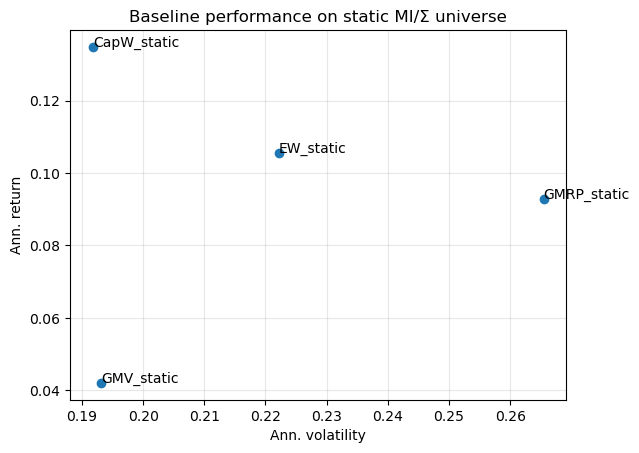

In [7]:
# Baseline out-of-sample performance on the static MI/Σ universe

# Summarize the baseline strategies side-by-side, using CapW as the benchmark.
baseline_rows: List[Dict[str, float]] = []
for name, r, w in [
    ("CapW_static", rets_cap,  w_cap_static),
    ("EW_static",   rets_ew,   w_ew_static),
    ("GMV_static",  rets_gmv,  w_gmv_static),
    ("GMRP_static", rets_gmrp, w_gmrp_static),
]:
    row = perf_summary(r, bench=bench, name=name)

    # Report MI-space risk for each static portfolio using the stabilized Q.
    row["sigma_Q"] = redundancy_sigma_Q(Q_reg, w)

    baseline_rows.append(row)

df_baseline = pd.DataFrame(baseline_rows).set_index("strategy")
display(df_baseline)

# Quick risk–return scatter for the baseline set.
plt.figure()
plt.scatter(df_baseline["ann_vol"], df_baseline["ann_ret"])
for s, row in df_baseline.iterrows():
    plt.annotate(s, (row["ann_vol"], row["ann_ret"]))
plt.xlabel("Ann. volatility")
plt.ylabel("Ann. return")
plt.title("Baseline performance on static MI/Σ universe")
plt.grid(True, alpha=0.3)
plt.show()

[Lever 1 joint] R_TRAIN_GMV_BASE shape (TRAIN log-returns): (1122, 927)

[Lever 1 joint] min_frac_obs = 0.05
[Lever 1 joint] required_weeks = 57 → n_assets = 926 (of 927 in static universe)
[Lever 1 joint] λ_Q=1.00e-05 | eig_min=1.000e-05 | eig_max=8.430e+02 | cond≈8.43e+07

[Lever 1 joint] min_frac_obs = 0.70
[Lever 1 joint] required_weeks = 786 → n_assets = 640 (of 927 in static universe)
[Lever 1 joint] λ_Q=1.00e-05 | eig_min=1.000e-05 | eig_max=6.070e+02 | cond≈6.07e+07

[Lever 1 joint] min_frac_obs = 0.80
[Lever 1 joint] required_weeks = 898 → n_assets = 617 (of 927 in static universe)
[Lever 1 joint] λ_Q=1.00e-05 | eig_min=1.000e-05 | eig_max=5.852e+02 | cond≈5.85e+07

[Lever 1 joint] min_frac_obs = 0.90
[Lever 1 joint] required_weeks = 1010 → n_assets = 570 (of 927 in static universe)
[Lever 1 joint] λ_Q=1.00e-05 | eig_min=1.000e-05 | eig_max=5.402e+02 | cond≈5.40e+07

[Lever 1 joint] min_frac_obs = 0.95
[Lever 1 joint] required_weeks = 1066 → n_assets = 550 (of 927 in static un

N   ann_ret   ann_vol    sharpe  info_ratio       mdd   sortino    calmar    dd_dev  n_assets  required_weeks  \
min_frac_obs strategy                                                                                                                    
0.05         GMRP      339  0.106619  0.295024  0.491572   -0.000873 -0.514512  0.100451  0.207224  0.200212       926              57   
             GMV       339  0.041780  0.193400  0.309616   -0.749469 -0.332924  0.058101  0.125493  0.142921       926              57   
0.70         GMRP      339 -0.927491  1.862721  0.242948    0.173815 -1.003109  0.048518 -0.924617  1.293462       640             786   
             GMV       339  0.060861  0.157370  0.454690   -0.672719 -0.266086  0.088543  0.228726  0.112068       640             786   
0.80         GMRP      339 -0.885726  1.987400  0.328909    0.268442 -1.019945  0.068684 -0.868406  1.319782       617             898   
             GMV       339  0.084075  0.157586  0.591660   -0.480180 -0.251300  0.116992  0.334559  0.110518       617             898   
0.90         GMRP      339 -0.882936  2.228163  0.351968    0.298804 -1.000046  0.076526 -0.882895  1.421149       570            1010   
             GMV       339  0.102481  0.158372  0.696197   -0.314794 -0.263021  0.137166  0.389630  0.111471       570            1010   
0.95         GMRP      339 -0.885958  2.018075  0.302485    0.241602 -1.000015  0.061914 -0.885945  1.367259       550            1066   
             GMV       339  0.102696  0.156687  0.703296   -0.313674 -0.259034  0.137845  0.396456  0.110860       550            1066   

                       lambda_Q   sigma_Q  
min_frac_obs strategy                      
0.05         GMRP       0.00001  0.000498  
             GMV        0.00001  0.172391  
0.70         GMRP       0.00001  0.007135  
             GMV        0.00001  1.001969  
0.80         GMRP       0.00001  0.007383  
             GMV        0.00001  1.003259  
0.90         GMRP       0.00001  0.007698  
             GMV        0.00001  1.005651  
0.95         GMRP       0.00001  0.007779  
             GMV        0.00001  1.005881

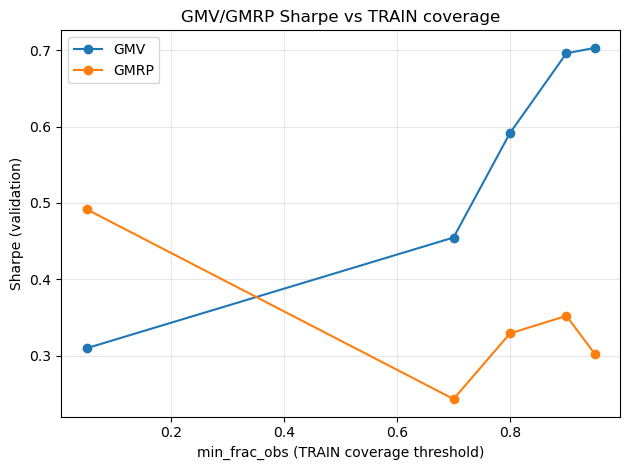

In [8]:
# Joint GMV + GMRP coverage; Σ and Q re-estimated on same universe

from ksg_tools import redundancy_for_opt  # KSG pipeline used in weekly_computation

# Coverage thresholds to probe (fraction of non-missing training weeks required).
min_frac_grid = [0.05, 0.70, 0.80, 0.90, 0.95]

# Base training panels on the static universe:
#   - GMV uses log returns (R_gmv_train_log from earlier)
#   - MI uses simple returns (R_train_pno from earlier)
R_TRAIN_GMV_BASE = R_gmv_train_log.loc[:, VAL_STATIC_IDS].copy()
R_TRAIN_MI_BASE = (
    R_train_pno
    .loc[(R_train_pno.index >= TRAIN_START) & (R_train_pno.index <= TRAIN_END), VAL_STATIC_IDS]
    .copy()
)

n_train_weeks = R_TRAIN_GMV_BASE.shape[0]
print(f"[Lever 1 joint] R_TRAIN_GMV_BASE shape (TRAIN log-returns): {R_TRAIN_GMV_BASE.shape}")

rows_l1_joint: list[dict] = []

for min_frac in min_frac_grid:
    print("\n" + "=" * 80)
    print(f"[Lever 1 joint] min_frac_obs = {min_frac:.2f}")
    print("=" * 80)

    # Translate the fraction threshold into a week count, respecting the hard floor.
    required_weeks = max(
        GMV_COVERAGE_FLOOR,
        int(np.ceil(min_frac * n_train_weeks))
    )

    # Coverage is measured on the GMV training panel (log returns).
    nn = R_TRAIN_GMV_BASE.notna().sum(axis=0)
    keep_ids = nn[nn >= required_weeks].index.astype(int).tolist()
    keep_ids = sorted(keep_ids)

    print(
        f"[Lever 1 joint] required_weeks = {required_weeks} → n_assets = {len(keep_ids)} "
        f"(of {len(VAL_STATIC_IDS)} in static universe)"
    )

    if len(keep_ids) < 2:
        print("[Lever 1 joint] fewer than 2 assets → skipping this threshold.")
        continue

    # GMV: estimate Σ on the covered universe (log-return covariance).
    R_train_gmv_cov = R_TRAIN_GMV_BASE.loc[:, keep_ids]
    Sigma_cov = shrinkage_cov_from_log(
        R_log=R_train_gmv_cov,
        alpha=SHRINK_ALPHA,
        ridge=SIGMA_RIDGE,
    )
    w_gmv_cov = gmv_weights(Sigma_cov)

    # GMRP: re-estimate the redundancy kernel on the same universe via KSG (pairwise overlap).
    R_train_mi_cov = R_TRAIN_MI_BASE.loc[:, keep_ids]

    NMI_opt_k, H_bits_k, MI_raw_k = redundancy_for_opt(
        df=R_train_mi_cov,
        start=None,
        end=None,
        use_log_returns=False,
        returns_are_log=False,
        standardize=True,
        min_obs=MI_MIN_OBS,
        k=KSG_K_BASE,
        normalize="sqrt",
        clamp_negative=False,
        shrink_eps=0.0,
        shuffle_debias=True,
        ns_shuffles=KSG_N_SHUFFLES,
        shuffle_seed=KSG_SHUFFLE_SEED,
        debias_only_if_leq=1e-6,
    )

    # Convert NMI to a redundancy kernel Q = 1 - NMI, then stabilize (PSD + ridge).
    R_nmi_cov = NMI_opt_k.reindex(index=keep_ids, columns=keep_ids)
    Q0_cov = 1.0 - R_nmi_cov.to_numpy(dtype="float64")
    Q0_cov = np.nan_to_num(Q0_cov, nan=0.0, posinf=0.0, neginf=0.0)
    Q0_cov = 0.5 * (Q0_cov + Q0_cov.T)
    np.fill_diagonal(Q0_cov, 0.0)

    Q_psd_cov = nearest_psd(Q0_cov, eps_eig=0.0)
    lam_q_cov = choose_ridge(
        Q_psd_cov,
        max_cond=Q_KAPPA_MAX,
        min_eig=Q_RIDGE_MIN_EIG,
    )
    Q_cov = Q_psd_cov + lam_q_cov * np.eye(Q_psd_cov.shape[0])
    Q_cov = 0.5 * (Q_cov + Q_cov.T)

    evals_cov = np.linalg.eigvalsh(Q_cov)
    print(
        f"[Lever 1 joint] λ_Q={lam_q_cov:.2e} | eig_min={evals_cov.min():.3e} "
        f"| eig_max={evals_cov.max():.3e} | cond≈{evals_cov.max()/max(evals_cov.min(),1e-12):.2e}"
    )

    w_gmrp_cov = gmrp_weights(Q_cov)

    # Validation returns on the same permno universe.
    R_val_cov = R_val_static.loc[:, keep_ids]

    r_gmv_cov = weighted_returns(R_val_cov, w_gmv_cov)
    r_gmrp_cov = weighted_returns(R_val_cov, w_gmrp_cov)

    # Record performance for both strategies at this coverage threshold.
    for strat_name, r, w in [
        ("GMV", r_gmv_cov, w_gmv_cov),
        ("GMRP", r_gmrp_cov, w_gmrp_cov),
    ]:
        row = perf_summary(r, bench=bench, name=strat_name)
        row.update(
            min_frac_obs=min_frac,
            n_assets=len(keep_ids),
            required_weeks=required_weeks,
            lambda_Q=lam_q_cov,
            sigma_Q=redundancy_sigma_Q(Q_cov, w),
        )
        rows_l1_joint.append(row)

df_l1_joint = (
    pd.DataFrame(rows_l1_joint)
    .set_index(["min_frac_obs", "strategy"])
    .sort_index()
)
display(df_l1_joint)

# Visual: Sharpe vs coverage threshold for GMV and GMRP.
plt.figure()
for strat in ["GMV", "GMRP"]:
    sub = df_l1_joint.xs(strat, level="strategy")
    plt.plot(sub.index, sub["sharpe"], marker="o", label=strat)
plt.xlabel("min_frac_obs (TRAIN coverage threshold)")
plt.ylabel("Sharpe (validation)")
plt.title("GMV/GMRP Sharpe vs TRAIN coverage")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

N   ann_ret   ann_vol    sharpe  info_ratio       mdd   sortino    calmar    dd_dev   sigma_Q
alpha ridge        strategy                                                                                                       
0.00  1.000000e-08 GMRP (fixed Q)  339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227  0.000406
                   GMV             339 -0.010283  0.225103  0.067455   -0.618951 -0.560294  0.012739 -0.018353  0.165290  0.222901
      1.000000e-06 GMV             339  0.017136  0.202412  0.185860   -0.626942 -0.460151  0.035196  0.037240  0.148226  0.197162
      1.000000e-04 GMV             339  0.064804  0.202813  0.412472   -0.745228 -0.373881  0.079248  0.173328  0.146387  0.110565
0.05  1.000000e-08 GMV             339  0.033835  0.189668  0.271299   -0.746217 -0.339182  0.050813  0.099755  0.140430  0.125030
      1.000000e-06 GMV             339  0.036320  0.189591  0.284009   -0.744567 -0.331391  0.053270  0.109599  0.140173  0.123416
      1.000000e-04 GMV             339  0.064493  0.202833  0.411024   -0.750040 -0.374112  0.078914  0.172391  0.146505  0.103854
0.10  1.000000e-08 GMV             339  0.040918  0.193093  0.305503   -0.746946 -0.330733  0.057292  0.123721  0.142787  0.108839
      1.000000e-06 GMV             339  0.042059  0.193124  0.311160   -0.747709 -0.332076  0.058410  0.126655  0.142668  0.108171
      1.000000e-04 GMV             339  0.064553  0.203398  0.410749   -0.752151 -0.376483  0.078848  0.171463  0.146936  0.100182
0.25  1.000000e-08 GMV             339  0.049657  0.200750  0.343413   -0.741381 -0.373306  0.064706  0.133020  0.147750  0.089077
      1.000000e-06 GMV             339  0.050046  0.200728  0.345270   -0.743156 -0.373401  0.065089  0.134028  0.147658  0.089017
      1.000000e-04 GMV             339  0.065714  0.205816  0.413712   -0.751312 -0.385741  0.079480  0.170357  0.148565  0.095101

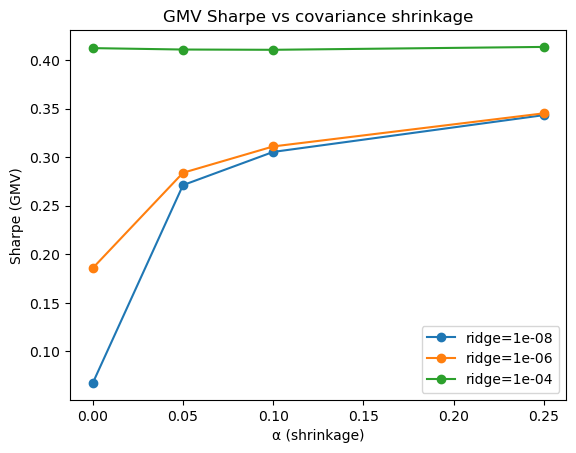

In [9]:
# Covariance shrinkage α and ridge λ_Σ (GMV only)

# Grid over diagonal shrinkage and eigenvalue ridge for the GMV covariance estimate.
alpha_grid = [0.00, 0.05, 0.10, 0.25]
ridge_grid = [1e-8, 1e-6, 1e-4]

rows_l2: List[Dict[str, float]] = []

for alpha in alpha_grid:
    for ridge in ridge_grid:
        # Rebuild Σ on the training log-return panel under this (alpha, ridge) setting.
        Sigma_alt = shrinkage_cov_from_log(R_gmv_train_log, alpha=alpha, ridge=ridge)

        # GMV weights live on the training axis; map them back to the static validation universe.
        w_gmv_alt_train = gmv_weights(Sigma_alt)
        w_gmv_alt = map_weights_to_static_universe(
            w_train=w_gmv_alt_train,
            train_ids=R_gmv_train_log.columns,
            static_ids=VAL_STATIC_IDS,
        )

        # Out-of-sample performance on the fixed validation return panel.
        r_gmv_alt = weighted_returns(Rval, w_gmv_alt)
        row_gmv = perf_summary(r_gmv_alt, bench=bench, name="GMV")
        row_gmv.update(
            alpha=alpha,
            ridge=ridge,
            sigma_Q=redundancy_sigma_Q(Q_reg, w_gmv_alt),
        )
        rows_l2.append(row_gmv)

        # Include the fixed-Q GMRP row once as a reference point for comparison.
        if alpha == alpha_grid[0] and ridge == ridge_grid[0]:
            r_gmrp = rets_gmrp
            row_gmrp = perf_summary(r_gmrp, bench=bench, name="GMRP (fixed Q)")
            row_gmrp.update(
                alpha=alpha,
                ridge=ridge,
                sigma_Q=redundancy_sigma_Q(Q_reg, w_gmrp_static),
            )
            rows_l2.append(row_gmrp)

df_l2 = (
    pd.DataFrame(rows_l2)
    .set_index(["alpha", "ridge", "strategy"])
    .sort_index()
)
display(df_l2)

# Plot of GMV Sharpe as a function of alpha, with separate curves for each ridge value.
plt.figure()
sub_all = df_l2.xs("GMV", level="strategy")
for ridge in ridge_grid:
    sub_r = sub_all.xs(ridge, level="ridge")
    plt.plot(sub_r.index.get_level_values("alpha"), sub_r["sharpe"], marker="o", label=f"ridge={ridge:.0e}")
plt.xlabel("α (shrinkage)")
plt.ylabel("Sharpe (GMV)")
plt.legend()
plt.title("GMV Sharpe vs covariance shrinkage")
plt.show()

N   ann_ret   ann_vol    sharpe  info_ratio       mdd   sortino    calmar    dd_dev   sigma_Q
lambda_Q strategy                                                                                                      
0.00000  GMRP           339 -0.003489  0.318346  0.148389   -0.375902 -0.579176  0.029397 -0.006023  0.222842  0.126434
         GMV (fixed Σ)  339  0.042059  0.193124  0.311160   -0.747709 -0.332076  0.058410  0.126655  0.142668  0.108168
0.00001  GMRP           339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227  0.000406
0.00010  GMRP           339  0.092817  0.265487  0.467866   -0.180696 -0.466013  0.094527  0.199173  0.182224  0.001283
0.00100  GMRP           339  0.092750  0.265431  0.467678   -0.181441 -0.465984  0.094484  0.199041  0.182196  0.004054

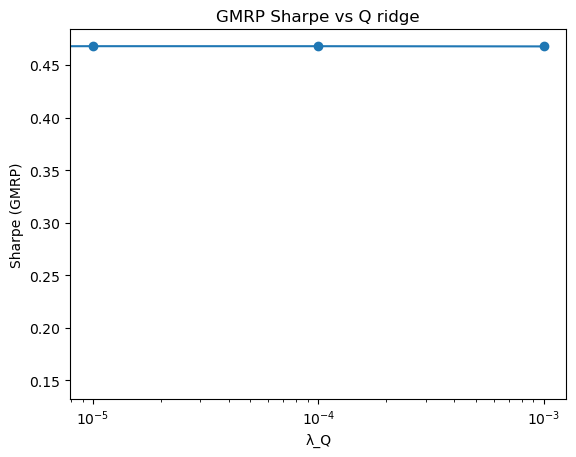

In [10]:
# MI-kernel ridge λ_Q (GMRP only)

# Sweep ridge values added after PSD projection, keeping everything else fixed.
lambda_q_grid = [0.0, Q_RIDGE_BASE_USED, 1e-4, 1e-3]

rows_l3: List[Dict[str, float]] = []

for lam_q in lambda_q_grid:
    # Start from the same raw Q0, project to PSD, then add the candidate ridge.
    Q_psd_local = nearest_psd(Q0, eps_eig=0.0)
    Q_reg_alt = Q_psd_local + lam_q * np.eye(Q_psd_local.shape[0])
    Q_reg_alt = 0.5 * (Q_reg_alt + Q_reg_alt.T)

    # GMRP weights implied by this stabilized kernel.
    w_gmrp_alt = gmrp_weights(Q_reg_alt)
    r_gmrp_alt = weighted_returns(Rval, w_gmrp_alt)

    row = perf_summary(r_gmrp_alt, bench=bench, name="GMRP")
    row.update(
        lambda_Q=lam_q,
        sigma_Q=redundancy_sigma_Q(Q_reg_alt, w_gmrp_alt),
    )
    rows_l3.append(row)

    # GMV doesn't depend on Q, but include it once for reference in the same table.
    if lam_q == lambda_q_grid[0]:
        row_gmv = perf_summary(rets_gmv, bench=bench, name="GMV (fixed Σ)")
        row_gmv.update(
            lambda_Q=lam_q,
            sigma_Q=redundancy_sigma_Q(Q_reg_alt, w_gmv_static),
        )
        rows_l3.append(row_gmv)

df_l3 = (
    pd.DataFrame(rows_l3)
    .set_index(["lambda_Q", "strategy"])
    .sort_index()
)
display(df_l3)

# Plot Sharpe as a function of the ridge value.
plt.figure()
sub = df_l3.xs("GMRP", level="strategy")
plt.plot(sub.index, sub["sharpe"], marker="o")
plt.xlabel("λ_Q")
plt.xscale("log")
plt.ylabel("Sharpe (GMRP)")
plt.title("GMRP Sharpe vs Q ridge")
plt.show()

N   ann_ret   ann_vol    sharpe  info_ratio       mdd   sortino    calmar    dd_dev   l1_norm   sigma_Q
max_abs_w strategy                                                                                                           
0.01      GMRP      339  0.087835  0.258971  0.455406   -0.249501 -0.456069  0.091582  0.192591  0.178581  2.926974  0.000418
          GMV       339  0.001754  0.206877  0.112391   -0.594477 -0.507968  0.021342  0.003453  0.151078  9.919905  0.397792
0.02      GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227  2.417072  0.000406
          GMV       339  0.030878  0.193015  0.254652   -0.606244 -0.396255  0.048490  0.077924  0.140567  5.920451  0.237585
0.05      GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227  2.417072  0.000406
          GMV       339  0.042329  0.190578  0.313965   -0.752053 -0.319151  0.059165  0.132630  0.140246  3.420087  0.132683
NaN       GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227  2.417072  0.000406
          GMV       339  0.042059  0.193124  0.311160   -0.747709 -0.332076  0.058410  0.126655  0.142668  2.972979  0.108171

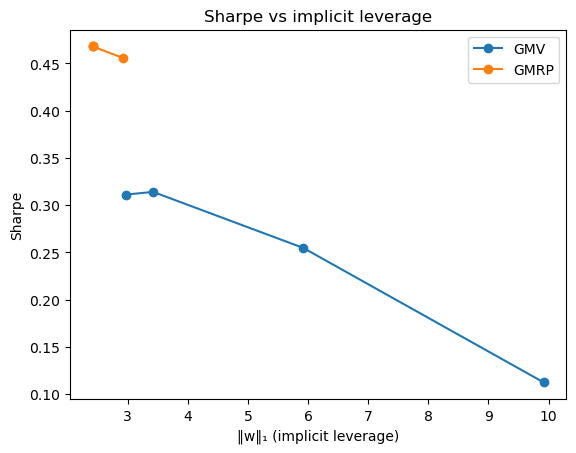

In [11]:
# Portfolio constraints / implicit leverage

# Sweep a simple per-name cap on absolute weights and see how performance moves.
max_abs_grid = [0.01, 0.02, 0.05]

rows_l4: List[Dict[str, float]] = []

def clip_weights(w: np.ndarray, max_abs: float) -> np.ndarray:
    # Hard-cap each position, then renormalize back to sum=1.
    w_clipped = np.clip(w, -max_abs, max_abs)
    if np.allclose(w_clipped, 0.0):
        return w_clipped
    w_clipped /= w_clipped.sum()
    return w_clipped

for c in max_abs_grid:
    w_gmrp_clip = clip_weights(w_gmrp_static, c)
    w_gmv_clip  = clip_weights(w_gmv_static,  c)

    for strat_name, w in [("GMRP", w_gmrp_clip), ("GMV", w_gmv_clip)]:
        r = weighted_returns(Rval, w)
        row = perf_summary(r, bench=bench, name=strat_name)
        row.update(
            max_abs_w=c,
            l1_norm=float(np.abs(w).sum()),
            sigma_Q=redundancy_sigma_Q(Q_reg, w),
        )
        rows_l4.append(row)

# Baseline (unconstrained) rows for reference.
for strat_name, w in [("GMRP", w_gmrp_static), ("GMV", w_gmv_static)]:
    r = weighted_returns(Rval, w)
    row = perf_summary(r, bench=bench, name=strat_name)
    row.update(
        max_abs_w=np.nan,
        l1_norm=float(np.abs(w).sum()),
        sigma_Q=redundancy_sigma_Q(Q_reg, w),
    )
    rows_l4.append(row)

df_l4 = (
    pd.DataFrame(rows_l4)
    .set_index(["max_abs_w", "strategy"])
    .sort_index()
)
display(df_l4)

# Plot Sharpe against implied leverage (L1 norm) across the cap settings.
plt.figure()
for strat in ["GMV", "GMRP"]:
    sub = df_l4.xs(strat, level="strategy")
    plt.plot(sub["l1_norm"], sub["sharpe"], marker="o", label=strat)
plt.xlabel("‖w‖₁ (implicit leverage)")
plt.ylabel("Sharpe")
plt.title("Sharpe vs implicit leverage")
plt.legend()
plt.show()

[GMV TRAIN] 372,888 duplicate rows across 186,444 (date, permno) keys.
[GMV TRAIN] 125,387 duplicate keys with spread > 1e-10; averaging.
[GMV TRAIN] df_ret shape = (1122, 927) (weekly rows × assets) before coverage filter.
[GMV TRAIN] after coverage ≥52, n_assets=927.
[GMV TRAIN] 332,346 duplicate rows across 166,173 (date, permno) keys.
[GMV TRAIN] 112,780 duplicate keys with spread > 1e-10; averaging.
[GMV TRAIN] df_ret shape = (965, 927) (weekly rows × assets) before coverage filter.
[GMV TRAIN] after coverage ≥52, n_assets=927.
[GMV TRAIN] 287,724 duplicate rows across 143,862 (date, permno) keys.
[GMV TRAIN] 97,500 duplicate keys with spread > 1e-10; averaging.
[GMV TRAIN] df_ret shape = (808, 927) (weekly rows × assets) before coverage filter.
[GMV TRAIN] after coverage ≥52, n_assets=927.
[GMV TRAIN] 240,164 duplicate rows across 120,082 (date, permno) keys.
[GMV TRAIN] 81,057 duplicate keys with spread > 1e-10; averaging.
[GMV TRAIN] df_ret shape = (652, 927) (weekly rows × ass

N   ann_ret   ann_vol    sharpe  info_ratio       mdd   sortino    calmar    dd_dev  train_end   sigma_Q
train_start strategy                                                                                                            
1997-01-03  GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227 2018-06-29  0.000406
            GMV       339  0.042059  0.193124  0.311160   -0.747709 -0.332076  0.058410  0.126655  0.142668 2018-06-29  0.108171
2000-01-07  GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227 2018-06-29  0.000406
            GMV       339  0.041755  0.193054  0.309763   -0.752616 -0.338845  0.058000  0.123228  0.142981 2018-06-29  0.109413
2003-01-10  GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227 2018-06-29  0.000406
            GMV       339  0.042732  0.190440  0.316325   -0.752865 -0.332399  0.059079  0.128557  0.141403 2018-06-29  0.112163
2006-01-06  GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227 2018-06-29  0.000406
            GMV       339  0.041829  0.189820  0.312258   -0.773409 -0.333951  0.058154  0.125256  0.141342 2018-06-29  0.117584
2009-01-09  GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227 2018-06-29  0.000406
            GMV       339  0.038539  0.188988  0.296189   -0.825806 -0.348017  0.054870  0.110739  0.141472 2018-06-29  0.123680
2012-01-06  GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227 2018-06-29  0.000406
            GMV       339  0.027970  0.197065  0.240486   -0.949188 -0.401472  0.044249  0.069668  0.148525 2018-06-29  0.147338
2015-01-09  GMRP      339  0.092824  0.265492  0.467886   -0.180619 -0.466016  0.094532  0.199187  0.182227 2018-06-29  0.000406
            GMV       339  0.027850  0.186362  0.242597   -1.030408 -0.377403  0.044488  0.073794  0.140929 2018-06-29  0.214231

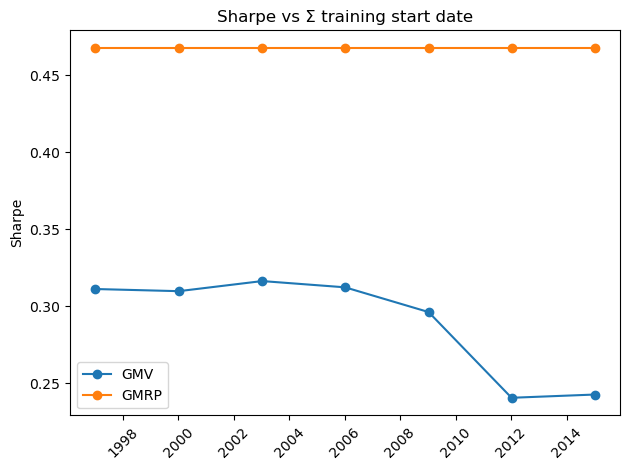

In [12]:
# ALternative Σ training windows (Q fixed)

# Vary the start date used to estimate Σ for GMV; keep Q and GMRP fixed.
train_start_grid = [
    pd.Timestamp("1997-01-03"),
    pd.Timestamp("2000-01-07"),
    pd.Timestamp("2003-01-10"),
    pd.Timestamp("2006-01-06"),
    pd.Timestamp("2009-01-09"),
    pd.Timestamp("2012-01-06"),
    pd.Timestamp("2015-01-09"),
]

rows_l5a: List[Dict[str, float]] = []

for t0 in train_start_grid:
    # Rebuild the GMV training log-return panel on the same static universe, but with a later start date.
    R_train_alt = build_gmv_train_panel_like_weekly_processing(
        coverage_floor=GMV_COVERAGE_FLOOR,
        train_start=t0,
        train_end=TRAIN_END,
        static_ids=VAL_STATIC_IDS,
    )
    if R_train_alt.empty:
        continue

    Sigma_alt = shrinkage_cov_from_log(R_train_alt, alpha=SHRINK_ALPHA, ridge=SIGMA_RIDGE)
    w_gmv_alt_train = gmv_weights(Sigma_alt)
    w_gmv_alt = map_weights_to_static_universe(
        w_train=w_gmv_alt_train,
        train_ids=R_train_alt.columns,
        static_ids=VAL_STATIC_IDS,
    )

    r_gmv_alt = weighted_returns(Rval, w_gmv_alt)
    row = perf_summary(r_gmv_alt, bench=bench, name="GMV")
    row.update(
        train_start=t0,
        train_end=TRAIN_END,
        sigma_Q=redundancy_sigma_Q(Q_reg, w_gmv_alt),
    )
    rows_l5a.append(row)

    # GMRP doesn't depend on Σ, but include a reference row for each start date for easy comparison.
    r_gmrp = rets_gmrp
    row_g = perf_summary(r_gmrp, bench=bench, name="GMRP")
    row_g.update(
        train_start=t0,
        train_end=TRAIN_END,
        sigma_Q=redundancy_sigma_Q(Q_reg, w_gmrp_static),
    )
    rows_l5a.append(row_g)

df_l5a = (
    pd.DataFrame(rows_l5a)
    .set_index(["train_start", "strategy"])
    .sort_index()
)
display(df_l5a)

# Plot Sharpe as a function of the Σ training start date.
plt.figure()
for strat in ["GMV", "GMRP"]:
    sub = df_l5a.xs(strat, level="strategy")
    plt.plot(sub.index, sub["sharpe"], marker="o", label=strat)
plt.xticks(rotation=45)
plt.ylabel("Sharpe")
plt.title("Sharpe vs Σ training start date")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Alternative Q training windows (Σ fixed, Q re-estimated via redundancy_for_opt)

from ksg_tools import redundancy_for_opt  # same helper used in weekly_computation

# Vary the start date for the MI/Q estimation window while keeping Σ fixed.
q_train_start_grid = [
    pd.Timestamp("1997-01-03"),
    pd.Timestamp("2001-01-05"),
    pd.Timestamp("2005-01-07"),
    pd.Timestamp("2010-01-08"),
    pd.Timestamp("2012-01-06")
]

rows_l5b: List[Dict[str, float]] = []

print("Running Lever 5b: MI/Q training windows (full KSG pipeline, k=6)…")

for t0 in q_train_start_grid:
    print("\n" + "=" * 80)
    print(f"[Lever 5b] MI/Q training window: {t0.date()} → {TRAIN_END.date()}")
    print("=" * 80)

    # Slice the training return panel (simple returns) on the static universe.
    R_train_alt = R_train_pno.loc[
        (R_train_pno.index >= t0) & (R_train_pno.index <= TRAIN_END),
        VAL_STATIC_IDS,
    ]

    # Re-estimate NMI via the same pipeline used in weekly_computation.
    NMI_opt_k, H_bits_k, MI_raw_k = redundancy_for_opt(
        df=R_train_alt,
        start=None,
        end=None,
        use_log_returns=False,
        returns_are_log=False,
        standardize=True,
        min_obs=MI_MIN_OBS,
        k=KSG_K_BASE,
        normalize="sqrt",
        clamp_negative=False,
        shrink_eps=0.0,
        shuffle_debias=True,
        ns_shuffles=KSG_N_SHUFFLES,
        shuffle_seed=KSG_SHUFFLE_SEED,
        debias_only_if_leq=1e-6,
    )

    # Convert NMI to redundancy kernel Q = 1 - NMI, then stabilize (PSD + ridge).
    R_nmi = NMI_opt_k.reindex(index=VAL_STATIC_IDS, columns=VAL_STATIC_IDS)
    Q0_alt = 1.0 - R_nmi.to_numpy(dtype="float64")
    Q0_alt = np.nan_to_num(Q0_alt, nan=0.0, posinf=0.0, neginf=0.0)
    Q0_alt = 0.5 * (Q0_alt + Q0_alt.T)
    np.fill_diagonal(Q0_alt, 0.0)

    Q_psd_alt = nearest_psd(Q0_alt, eps_eig=0.0)
    lam_q_alt = choose_ridge(Q_psd_alt, max_cond=Q_KAPPA_MAX, min_eig=Q_RIDGE_MIN_EIG)
    Q_alt = Q_psd_alt + lam_q_alt * np.eye(Q_psd_alt.shape[0])
    Q_alt = 0.5 * (Q_alt + Q_alt.T)

    evals = np.linalg.eigvalsh(Q_alt)
    print(
        f"[Lever 5b] λ_Q={lam_q_alt:.2e} | eig_min={evals.min():.3e} "
        f"eig_max={evals.max():.3e} cond≈{evals.max()/max(evals.min(),1e-12):.2e}"
    )

    # GMRP weights implied by this window-specific Q estimate.
    w_gmrp_alt = gmrp_weights(Q_alt)
    r_gmrp_alt = weighted_returns(R_val_static, w_gmrp_alt)

    # GMV remains fixed because Σ is fixed in this lever.
    r_gmv_alt = rets_gmv

    row_gmrp = perf_summary(r_gmrp_alt, bench=bench, name="GMRP")
    row_gmrp.update(
        q_train_start=t0,
        q_train_end=TRAIN_END,
        lambda_Q=lam_q_alt,
        sigma_Q=redundancy_sigma_Q(Q_alt, w_gmrp_alt),
    )
    rows_l5b.append(row_gmrp)

    row_gmv = perf_summary(r_gmv_alt, bench=bench, name="GMV (fixed Σ)")
    row_gmv.update(
        q_train_start=t0,
        q_train_end=TRAIN_END,
        lambda_Q=lam_q_alt,
        sigma_Q=redundancy_sigma_Q(Q_alt, w_gmv_static),
    )
    rows_l5b.append(row_gmv)

df_l5b = (
    pd.DataFrame(rows_l5b)
    .set_index(["q_train_start", "strategy"])
    .sort_index()
)
display(df_l5b)

# Plot Sharpe vs Q training start date.
plt.figure()
for strat in ["GMV (fixed Σ)", "GMRP"]:
    sub = df_l5b.xs(strat, level="strategy")
    plt.plot(sub.index, sub["sharpe"], marker="o", label=strat)
plt.xticks(rotation=45)
plt.ylabel("Sharpe")
plt.title("Sharpe vs Q training start date")
plt.legend()
plt.tight_layout()
plt.show()

Running Lever 5b: MI/Q training windows (full KSG pipeline, k=6)…

[Lever 5b] MI/Q training window: 1997-01-03 → 2018-06-29
[Lever 5b] λ_Q=1.00e-05 | eig_min=1.000e-05 eig_max=8.430e+02 cond≈8.43e+07

[Lever 5b] MI/Q training window: 2001-01-05 → 2018-06-29
[Lever 5b] λ_Q=1.00e-05 | eig_min=1.000e-05 eig_max=8.396e+02 cond≈8.40e+07

[Lever 5b] MI/Q training window: 2005-01-07 → 2018-06-29


In [ ]:
# KSG k-nearest-neighbour hyperparameter

# Probe sensitivity of the kernel (and GMRP performance) to the KSG k choice.
k_grid = [3, 4, 6, 8, 10]
rows_l6: List[Dict[str, float]] = []

print("Running Lever 6: KSG k-neighbour hyperparameter…")

for k_val in k_grid:
    print("\n" + "=" * 80)
    print(f"[Lever 6] Re-estimating Q with k = {k_val}")
    print("=" * 80)

    # Full training window on the static universe (simple returns in).
    R_train_mi = R_train_pno.loc[
        (R_train_pno.index >= TRAIN_START) & (R_train_pno.index <= TRAIN_END),
        VAL_STATIC_IDS,
    ]

    # Rebuild NMI via the full redundancy_for_opt pipeline with k = k_val.
    NMI_opt_k, H_bits_k, MI_raw_k = redundancy_for_opt(
        df=R_train_mi,
        start=None,
        end=None,
        use_log_returns=False,
        returns_are_log=False,
        standardize=True,
        min_obs=MI_MIN_OBS,
        k=k_val,
        normalize="sqrt",
        clamp_negative=False,
        shrink_eps=0.0,
        shuffle_debias=True,
        ns_shuffles=KSG_N_SHUFFLES,
        shuffle_seed=KSG_SHUFFLE_SEED,
        debias_only_if_leq=1e-6,
    )

    # Convert NMI to redundancy kernel Q = 1 - NMI, then stabilize.
    R_nmi_k = NMI_opt_k.reindex(index=VAL_STATIC_IDS, columns=VAL_STATIC_IDS)
    Q0_k = 1.0 - R_nmi_k.to_numpy(dtype="float64")
    Q0_k = np.nan_to_num(Q0_k, nan=0.0, posinf=0.0, neginf=0.0)
    Q0_k = 0.5 * (Q0_k + Q0_k.T)
    np.fill_diagonal(Q0_k, 0.0)

    Q_psd_k = nearest_psd(Q0_k, eps_eig=0.0)
    lam_q_k = choose_ridge(Q_psd_k, max_cond=Q_KAPPA_MAX, min_eig=Q_RIDGE_MIN_EIG)
    Q_k = Q_psd_k + lam_q_k * np.eye(Q_psd_k.shape[0])
    Q_k = 0.5 * (Q_k + Q_k.T)

    evals_k = np.linalg.eigvalsh(Q_k)
    print(
        f"[Lever 6] λ_Q={lam_q_k:.2e} | eig_min={evals_k.min():.3e} "
        f"eig_max={evals_k.max():.3e} cond≈{evals_k.max()/max(evals_k.min(),1e-12):.2e}"
    )

    # GMRP weights and validation performance under this kernel.
    w_gmrp_k = gmrp_weights(Q_k)
    r_gmrp_k = weighted_returns(R_val_static, w_gmrp_k)

    row = perf_summary(r_gmrp_k, bench=bench, name="GMRP")
    row.update(
        k=k_val,
        lambda_Q=lam_q_k,
        sigma_Q=redundancy_sigma_Q(Q_k, w_gmrp_k),
    )
    rows_l6.append(row)

df_l6 = pd.DataFrame(rows_l6).set_index("k").sort_index()
display(df_l6)

# Plot Sharpe vs k.
fig, ax = plt.subplots()
ax.plot(df_l6.index, df_l6["sharpe"], marker="o")
ax.set_xlabel("KSG k")
ax.set_ylabel("Sharpe (GMRP)")
ax.set_title("GMRP Sharpe vs k")
plt.tight_layout()
plt.show()

# Plot sigma_Q vs k.
fig, ax = plt.subplots()
ax.plot(df_l6.index, df_l6["sigma_Q"], marker="o")
ax.set_xlabel("KSG k")
ax.set_ylabel("σ_Q(GMRP)")
ax.set_title("Lever 6: redundancy vs k")
plt.tight_layout()
plt.show()